# Project roadmap and code

## Table of contents
1. [Questions](#1\.-Questions)
2. [Schedule](#2\.-Schedule)
3. [Documentation and first hands-on](#3\.-Documentation-and-first-hands-on)
4. [Data generation](#4\.-Data-generation)
5. [Data processing](#5\.-Data-processing)
6. [Machine learning](#6\.-Machine-learning)

## 1. Questions

Questions I wonder are grouped here:

- *In IGV usage*: **Question:** I'm not sure how to understand the vcf file in IGV, how do I know if it's an insertion or a deletion? Do the files I loaded correspond to one another?
- *In Data processing*: **Question:** Since we 'stream' data what's the best way to split train/test. Split certain positions? Split while iterating over batches? Train on chromosome 2, test on chromosome 1?

## 2. Schedule

### Week 1
- Meeting and get in touch with colleagues and Rick's work ✔️
- Download data and visualize with IGV ✔️
- Get in touch with formats (vcf, bam, ...) ✔️
- Read gnomAD paper ✔️

### Week 2
- Look at how they extract their features in the papers ✔️
- Extract data with Canevas from one genome of Genome in a Bottle ✔️
- Load data and pre-process it if needed ✔️
- Process data in python, vcf, signals data ✔️

### Week 3
- Check different approaches taken by papers to maybe take inspiration of window sizes or similar
- Filter VCF to event that pass filters
- Generate data by taking breakpoints of vcf and computing windows around them and windows with no events
- Split tain test
- Train model (deep net or random forest)

### Week 4
- Continue machine learning models
- Validate, compute performance

### Week 5
To be determined... (if work left, enough time, ...)

## 3. Documentation and first hands-on

This section will contain the steps done towards documentation, data exploration, IGV usage

### IGV usage

First, I downloaded [IGV 2.8.3](http://software.broadinstitute.org/software/igv/download) for Linux

Then I downloaded this data [here](ftp://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/data/NA12878/NA12878_PacBio_MtSinai/) from [Genome in a Bottle](https://www.nist.gov/programs-projects/genome-bottle):
- `NA12878.sorted.vcf.gz`
- `NA12878.sorted.vcf.gz.tbi`
- `README.txt`
- `merged_ec_output_primary.bam`
- `merged_ec_output_primary.bam.bai`

I tried to load `NA12878.sorted.vcf.gz` and `merged_ec_output_primary.bam` in IGV but there was a parsing error in the vcf file:
- I realized line 4 `#contig=<ID=chr1,...` was missing a `#` at the begginning
- I had to change the spaces in the header line to `\t`

I then was able to load the two files in IGV and have a visualization:

**Question:** I'm not sure how to understand the vcf file in IGV, how do I know if it's an insertion or a deletion? Do the files I loaded correspond to one another?

![IGV image](images/igv-NA12878-1.png)

## 4. Data generation

This section will contain the steps done towards data creation with [Canevas](https://github.com/rick-heig/canevas), different filters used

The `bam` file `merged_ec_output_primary.bam` I had was in long reads, thus it wasn't usable in Canevas and wasn't the format we want.

I asked the Genome Center for a short reads `bam` file on one chromosome and for now Rick gave me data generated with Canevas on `Guipponi.NA12878-A.mdup.sorted.bam.bqsr.bam` for chromosome 21 to start with

I then downloaded the `RMNISTHS_30xdownsample.bam` at ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/NA12878/NIST_NA12878_HG001_HiSeq_300x/ and extracted the features for chromosome 2, using Canevas and this very command:

`sbt run signal extract -b /home/lulu/Documents/Work/genome-center/data/RMNISTHS_30xdownsample.bam -o out -r 2`

## 5. Data processing

This section will contain the steps done towards data processing in order to use it in the machine learning pipeline

There is a *lot* of data, we can't load all signals for the whole chromosome at the same time.

When training, we have to get part of the data, train on it and get next chunk. Otherwise we won't have enough memory

To do that, I decided to go for an object-oriented approach, since I want the 'readers' to have states. I ask for the next batch and it returns it, keeping the next values already loaded.

That way later I should be able to load a batch of each signal, split the batch in mini_batches, train the model on them and then load the next batches.

I added MultiSignal to combine signals easily and get multiple batches.

Then I added a `SignalExtractor` for VCF, given a vcf file, when requested a batch it would say which positions were deleted. First I had a `np.vectorize` function to do that, similar to a map; that checked each position in the vcf file. But it was slow, so I changed to a broadcasting way where I utilize numpy's way of doing it, which greatly sped up running time.

In [1]:
%load_ext line_profiler

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pybedtools import BedTool

In [2]:
metadata_size = 3 # Number of metadata lines in bedgraph

chunk_size = 10000 # Number of lines read on bedgraph per iter
batch_size = 1000 # Number of values returned by SignalExtractor when asked for a batch

In [3]:
class SignalExtractor():
    def get_next_batch(self):
        raise NotImplementedError
        
    def has_next(self):
        raise NotImplementedError
        
    def reset(self):
        raise NotImplementedError

In [4]:
class SingleSignalExtractor(SignalExtractor):
    def __init__(self, bedgraph, data_dir='data/', metadata_size=metadata_size):
        self.bedgraph = BedTool(f'{data_dir}{bedgraph}')
        self.metadata_size = metadata_size
        self.skiprows = metadata_size # Remove metadata
        self.chunks_available = True
        self.batch_available = True
        self.remaining_values = np.array([])
        
        
    def get_next_batch(self):
        """
        Get next batch, which will have the `batch_size` next values. Can be smaller if there aren't enough values left
        """
        assert(self.has_next())
        
        if self.remaining_values.shape[0] >= batch_size:
            # There are enough values already read
            temp = self.remaining_values[:batch_size]
            self.remaining_values = self.remaining_values[batch_size:]
            return temp
        
        # Read next values
        df = self.bedgraph.to_dataframe(skiprows=self.skiprows, nrows=chunk_size)
        assert(df.isnull().sum().sum() == 0) # Check no missing values
        self.skiprows += len(df)
        
        # If there aren't as many rows as asked for, we are at the end of the file
        if len(df) < chunk_size:
            self.chunks_available = False
        
        # Repeat values the stated amount of time, since we want a continuous array of data
        df['repeat'] = df['end'] - df['start']
        df = df.drop(columns=['chrom', 'start', 'end'])
        df = df.reindex(df.index.repeat(df['repeat'])).reset_index(drop=True)
        df = df.drop(columns=['repeat'])
        
        # Put values in numpy and concatenate with previously loaded data
        values = df['name'].values
        values = np.concatenate([self.remaining_values, values])
        
        # Save remaining values and return batch
        self.remaining_values = values[batch_size:]
        
        self.batch_available = len(self.remaining_values) >= batch_size
        
        return values[:batch_size]
        
        
    def has_next(self):
        return self.chunks_available or self.batch_available
        
        
    def reset(self):
        self.skiprows = self.metadata_size
        self.chunks_available = True
        self.remaining_values = np.array([])

In [5]:
class MultiSignalExtractors(SignalExtractor):
    """
    Helper class to easily combine multiple signal extractors
    """
    def __init__(self, bedgraphs):
        self.signals = []
        
        for bedgraph in bedgraphs:
            if isinstance(bedgraph, SignalExtractor):
                self.signals.append(bedgraph)
            elif isinstance(bedgraph, str):
                self.signals.append(SingleSignalExtractor(bedgraph))
            else:
                raise ValueError
        
        
    def get_next_batch(self):
        """
        Get next batch for each signal and return them
        """
        batches = [signal.get_next_batch() for signal in self.signals]
        return np.stack(batches)
        
        
    def has_next(self):
        for signal in self.signals:
            if not signal.has_next():
                return False
        
        return True
        
        
    def reset(self):
        for signal in self.signals:
            signal.reset()

In [6]:
class VCFSignalExtractor(SignalExtractor):
    def __init__(self, vcf, data_dir='data/'):
        self.data = pd.read_table(f'{data_dir}{vcf}',
                                  skiprows=1,
                                  names=['chrom', 'pos', 'id', 'ref', 'alt', 'qual', 'filter', 'info', 'format', 'NA12878'],
                                  na_values='.')
    
        self.data = self.data[self.data['alt'] == '<DEL>'] # Only keep deletions
        #self.data = self.data[self.data['NA12878'] == '0/1'] # Filter NA12878?
        # Filter to deletions that pass at least 3 filters
        self.data['end'] = self.data['info'].str.extract(r'^.*END=(\d+);.*$').astype(int)
        self.data = self.data.drop(columns=['id', 'ref', 'alt', 'qual', 'filter', 'info', 'format', 'NA12878'])
        self.data = self.data.rename(columns={'pos': 'start'})
        self.data = self.data.reset_index(drop=True)
                
        self.current_index = 0
        self.last_returned_pos = 0
        
    
    def _classify_batch(self, batch, requested_pos):
        """
        With broadcasting, check if positions are in-between a start-end pair or not and classify them
        All positions are >= 0, so while processing values >= 0 are not classified yet
            During computation:
            - `-2` means no deletion
            - `-1` means deletion
        """
        index = self.current_index
        while np.sum(batch >= 0) > 0:
            if index >= len(self.data):
                # No more data in vcf, so assume there are no deletions afterwards 
                batch[batch >= 0] = -2
            else:
                _, start, end = self.data.loc[index]
                
                # Before start, so if it wasn't classified yet, it's not deleted
                batch[(batch >= 0) & (batch < start)] = -2
                
                # Before end, so if it wasn't classified yet, it's between start and end -> deleted
                batch[(batch >= 0) & (batch < end)] = -1
                
                if end < requested_pos:
                    # Line is no longer needed, as we are further than it
                    self.current_index += 1
                
                index += 1
        
    
    def get_next_batch(self):
        requested_pos = self.last_returned_pos + batch_size
        
        if self.current_index >= len(self.data):
            # No more data in vcf, so assume there are no deletions afterwards
            self.last_returned_pos = requested_pos
            return np.zeros(batch_size)
        
        batch = np.arange(self.last_returned_pos, requested_pos)
        
        self._classify_batch(batch, requested_pos)
        
        # Convert temporary values used
        batch[batch == -2] = 0
        batch[batch == -1] = 1
        
        self.last_returned_pos = requested_pos
        return batch
        
        
    def has_next(self):
        # Always has_next since we assume that if there is no data left in vcf, there are no deletions
        return True
        
        
    def reset(self):
        self.current_index = 0
        self.last_returned_pos = 0

In [7]:
signals = [
    VCFSignalExtractor('NA12878.sorted.chr2.vcf'),
    '2_CigarIndels.bedgraph.gz',
    '2_Clipped.bedgraph.gz',
    '2_Coverage.bedgraph.gz',
    '2_DiscordantTandemOrientation.bedgraph.gz',
    '2_ForwardInsertSizeTooBig.bedgraph.gz',
    '2_InsertSizeTooBig.bedgraph.gz',
    '2_InsertSizeTooSmall.bedgraph.gz',
    '2_InterChr.bedgraph.gz',
    '2_MappingErrors.bedgraph.gz',
    '2_MAPQ0.bedgraph.gz',
    '2_MateUnmapped.bedgraph.gz'
]

signal_extractor = MultiSignalExtractors(signals)

In [8]:
%%time

batch = np.zeros((len(signals), batch_size))

while np.sum(batch[0, :]) <= 300: # Iterate until we have a deletion
    batch = signal_extractor.get_next_batch()

CPU times: user 2.13 s, sys: 428 ms, total: 2.56 s
Wall time: 2.56 s


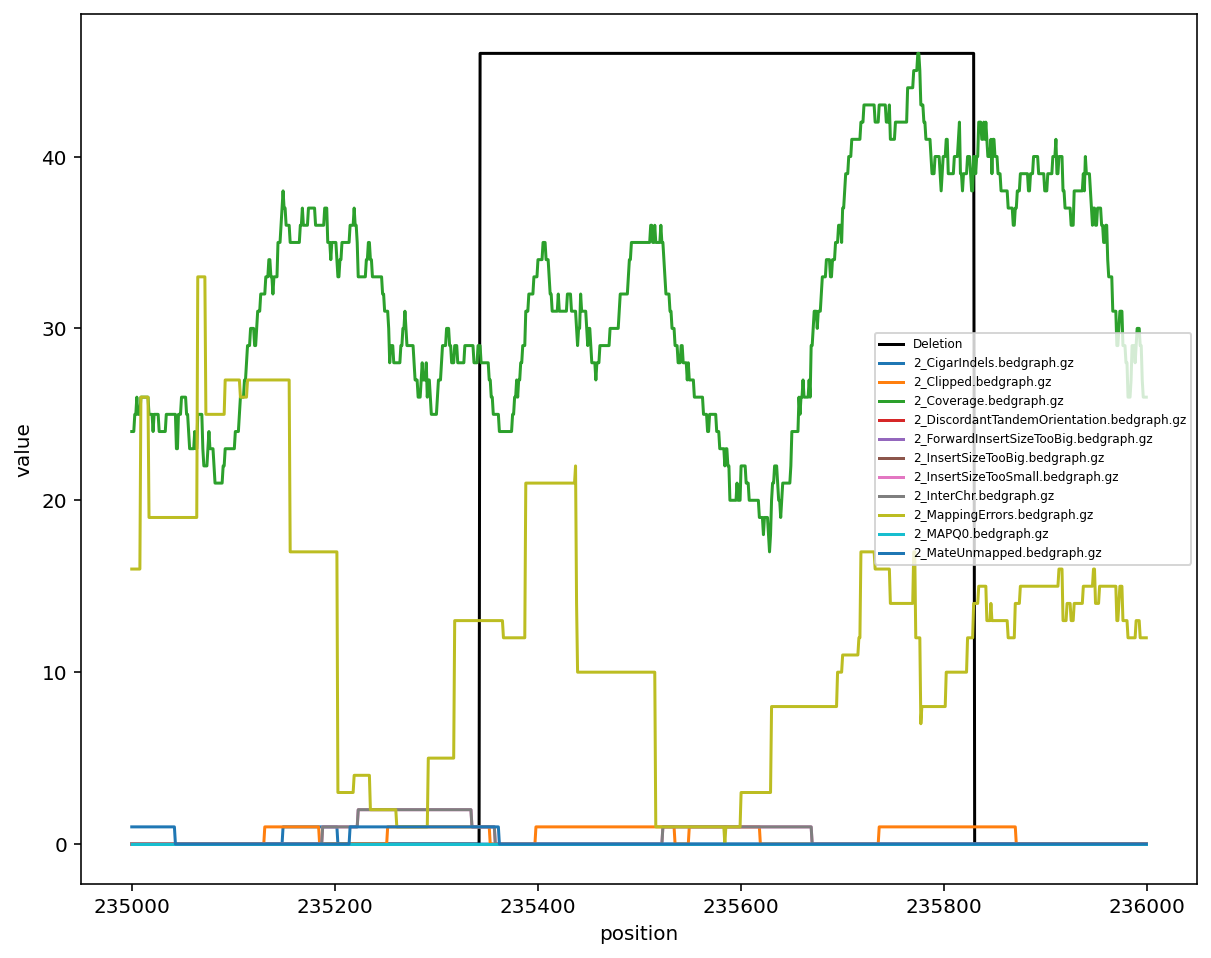

In [9]:
plt.figure(figsize=(10, 8), dpi=144)

x = np.arange(-batch_size, 0) + signals[0].last_returned_pos

plt.plot(x, batch[0]*np.max(batch), label='Deletion', color='black')


for i, signal in enumerate(batch[1:]):
    name = signals[i+1]
    plt.plot(x, signal, label=name)
    
plt.xlabel('position')
plt.ylabel('value')
plt.legend(fontsize=6)
plt.show()

## 6. Machine learning

## First idea
- Multiple Conv1d on each signal separately (maybe could use Conv2d for faster execution time, if implemented carefully, kernel of dim 1-x to treat signals differently)
- Then combine all signals and make a decision (2 dimensions, 1 hot encoded) with a few linear layers
- Since I don't have the whole data at one time, I can't really standardize homogeneously, which may be a proble
- To stabilize and fasten training I could make use of batch normalization
- I may also look at dropout, in order to have a model that generalizes better

How should the output be?
1. Give it a window of size 51 for example and it says if the middle value 26 is a deletion or not?
2. Give a window of size x returns x binary outputs

First may be simpler to train

We might have an issue because of the hugely unbalanced classes, deep nets usually avoid this issue but it may be a problem here. Maybe have a special loss where missclassifying a deletion is a huge error compared to missclassifying a not-deletion.